In [ ]:
# install tensorflow
import tensorflow as tf

# improved notebook for classifying the CIFAR10 dataset using convolutional neural network

this notebook aims to fix overfitting and increase accuracy using batch normalization 

In [ ]:
# other imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [ ]:
# load the data, included in tf
cifar10 = tf.keras.datasets.cifar10

# load data reutrns two tuples
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# scale x data, flatten y data (targets are 2D (N x 1), so flatten to 1D)
x_train, x_test = x_train/255., x_test/255.
y_train, y_test = y_train.flatten(), y_test.flatten()
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)

x_train.shape =  (50000, 32, 32, 3)
y_train.shape =  (50000,)


In [ ]:
# deduce number of classes (K), or the number of unique values in y_train 
K = len(set(y_train))
print('number of classes:', K)

number of classes: 10


In [ ]:
from keras.backend import batch_normalization
# now to build the model using keras functional API 
# this model will look different - here's where batch norm is implemented
i = Input(shape=x_train[0].shape)

# first change, remove the strided convolutions 
#x = Conv2D(32 , (3,3), strides=2, activation='relu')(i) 
#x = Conv2D(64 , (3,3), strides=2, activation='relu')(x) 
#x = Conv2D(128, (3,3), strides=2, activation='relu')(x) 

# next, implement convolution layers followed by batch norm layers
# but also, we'll follow the structure of the VGG network and do multiple conv layers
# before doing any pooling (see below)
# also: same padding is added so the images don't shrink after each conv layer

# the pattern is: conv > batch norm > conv > batch norm > pooling
x = Conv2D(32 , (3,3), activation='relu', padding='same')(i) 
x = BatchNormalization()(x)
x = Conv2D(32 , (3,3), activation='relu', padding='same')(i) 
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64 , (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x) 
x = Conv2D(64 , (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x) 
x = MaxPooling2D((2,2))(x)


x = Conv2D(128, (3,3), activation='relu', padding='same')(x) 
x = BatchNormalization()(x) 
x = Conv2D(128, (3,3), activation='relu', padding='same')(x) 
x = BatchNormalization()(x) 
x = MaxPooling2D((2,2))(x)
# you can include dropout after each pooling layer, but we won't here

# then we include the final dense layers as they were before 
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

In [ ]:
# compile and fit the model
# this takes some time, so make sure to use the GPU for this
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# note: we're increasing the training epochs here 
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50) 

# just calling fit will already give better results than before

Epoch 1/50
1563/1563 [==============================] - 28s 8ms/step - loss: 1.3622 - accuracy: 0.5294 - val_loss: 1.7113 - val_accuracy: 0.4819
Epoch 2/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.9168 - accuracy: 0.6788 - val_loss: 0.9317 - val_accuracy: 0.6726
Epoch 3/50
1563/1563 [==============================] - 14s 9ms/step - loss: 0.7600 - accuracy: 0.7359 - val_loss: 0.9065 - val_accuracy: 0.6986
Epoch 4/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6416 - accuracy: 0.7789 - val_loss: 0.8535 - val_accuracy: 0.7220
Epoch 5/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5526 - accuracy: 0.8080 - val_loss: 0.7884 - val_accuracy: 0.7459
Epoch 6/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.4643 - accuracy: 0.8386 - val_loss: 0.7131 - val_accuracy: 0.7556
Epoch 7/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.3958 - accuracy: 0.8619 - val_loss: 0.6250 - val_ac

KeyboardInterrupt: ignored

In [ ]:
# now we'll fit with data augmentation to see if we can correct any overfitting (see written notes)
# note: if you run this *after* running the previous block (model.fit), it will continue training
# which might be good for finetuning later, but back-to-back calls means you'll be running this
# on already trained weights

# compile model 
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
r = model.fit(
    train_generator, 
    validation_data=(x_test, y_test), 
    steps_per_epoch=steps_per_epoch,
    epochs=50
)

Epoch 1/50
1562/1562 [==============================] - 40s 23ms/step - loss: 1.4777 - accuracy: 0.4824 - val_loss: 1.1783 - val_accuracy: 0.5861
Epoch 2/50
1562/1562 [==============================] - 36s 23ms/step - loss: 1.0887 - accuracy: 0.6182 - val_loss: 0.8968 - val_accuracy: 0.6861
Epoch 3/50
1562/1562 [==============================] - 35s 22ms/step - loss: 0.9371 - accuracy: 0.6747 - val_loss: 0.9470 - val_accuracy: 0.6781
Epoch 4/50
1562/1562 [==============================] - 34s 22ms/step - loss: 0.8424 - accuracy: 0.7081 - val_loss: 0.8279 - val_accuracy: 0.7158
Epoch 5/50
1562/1562 [==============================] - 36s 23ms/step - loss: 0.7681 - accuracy: 0.7366 - val_loss: 0.7159 - val_accuracy: 0.7540
Epoch 6/50
1562/1562 [==============================] - 36s 23ms/step - loss: 0.7117 - accuracy: 0.7543 - val_loss: 0.8159 - val_accuracy: 0.7302
Epoch 7/50
1562/1562 [==============================] - 35s 23ms/step - loss: 0.6670 - accuracy: 0.7706 - val_loss: 0.6655 -

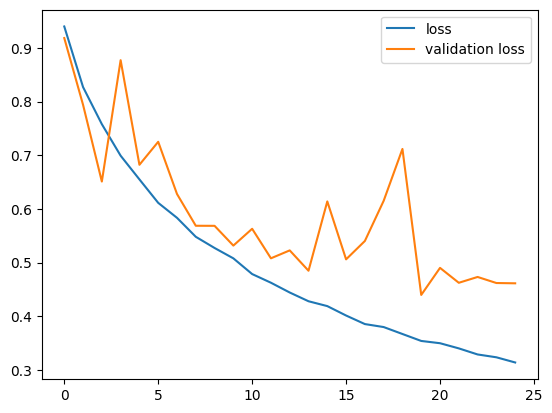

In [23]:
# plot loss per iteration 
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

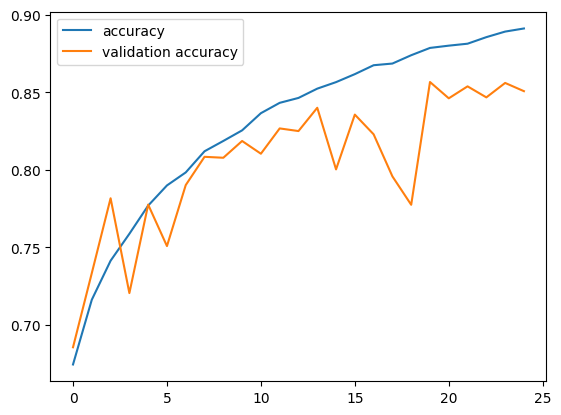

In [24]:
# plot accuracy per iteration 
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

313/313 [==============================] - 1s 3ms/step
confusion matrix without normalization
[[882   7  26   6  15   0   5   4  38  17]
 [  9 919   3   1   1   1   1   0  20  45]
 [ 32   3 769  40  69  26  39  12   4   6]
 [ 15   3  29 742  70  57  43  13  15  13]
 [ 10   1  18  27 899   9  19  13   3   1]
 [  6   3  26 184  50 669  27  21   7   7]
 [  7   1  14  29  15   2 922   1   7   2]
 [ 13   0  13  36  47  26   4 848   5   8]
 [ 32   6   4   4   5   0   2   0 939   8]
 [ 17  28   1   5   4   0   7   3  17 918]]


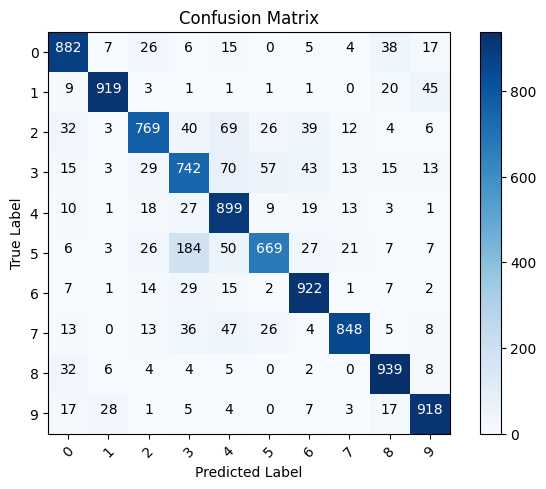

In [25]:
# plot confusion matrix
# this tells us: for each label, how many predictions corresponded to that label
# we want most of the entries to be on the diagonal (i.e. entries = prediction)

# the following function requires sklearn and itertools
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Confusion Matrix', 
                          cmap=plt.cm.Blues): 
  """
  This function prints and plots the confusion matrix, 
  normalization can be applied by setting normalize=True.
  """
  if normalize: 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("normalized confusion matrix")
  else: 
    print("confusion matrix without normalization")

  print(cm)
    
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): 
    plt.text(j, i, format(cm[i,j], fmt), 
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black') 

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))  

In [26]:
# label mapping
labels = '''airplane
automobile
bird
cat
deer 
dog
frog
horse
ship
truck'''.split()

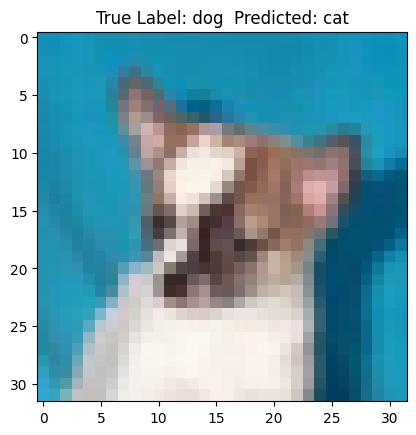

In [27]:
# plot misclassified examples
# index of misclassified predictions using np.where
# np.where returns two values, but index is first (hence [0])
misclassified_idx = np.where(p_test != y_test)[0]

# select a random index and plot
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title('True Label: %s  Predicted: %s' % (labels[y_test[i]], labels[p_test[i]]))
plt.show()